In [1]:
import os
import requests

def save_and_cache(url, path, force=False):
    if not os.path.exists(path) or force:
        print(f"Downloading {url} to {path} ...")
        r = requests.get(url)
        with open(path, 'wb') as f:
            f.write(r.content)

# 疫情数据

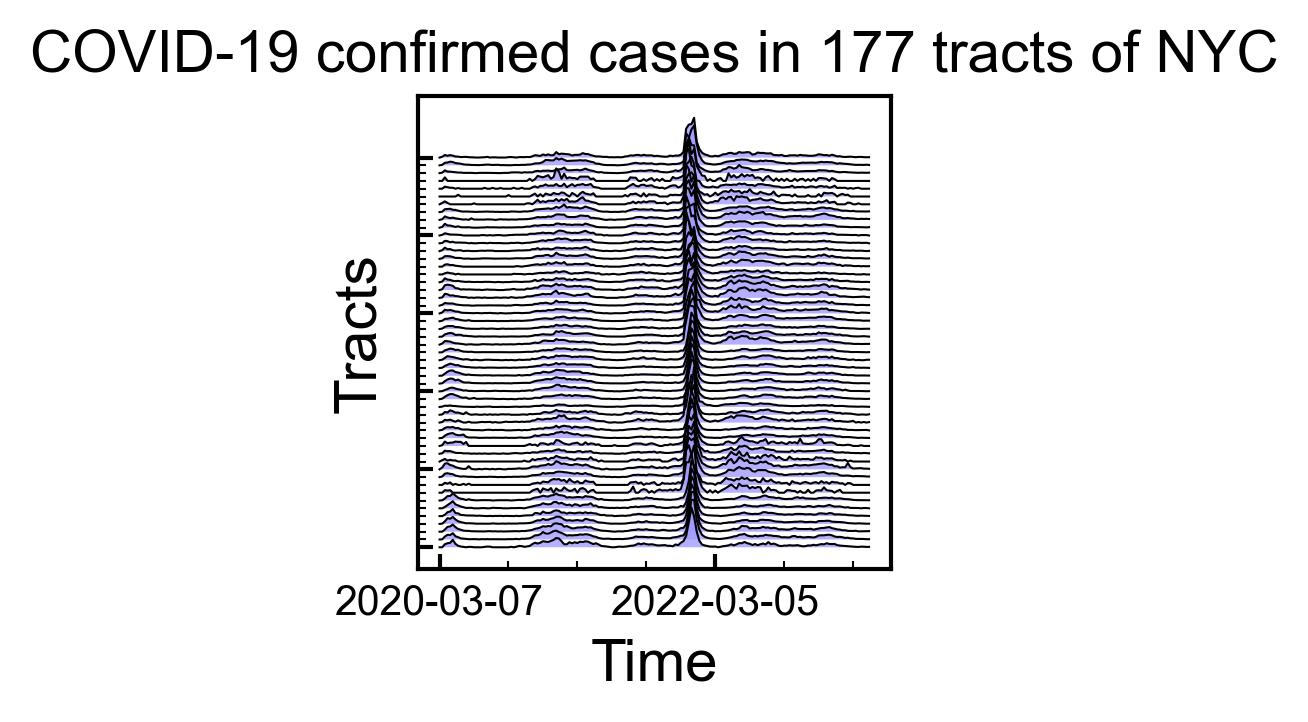

(177,) (163,) (163, 177)


In [2]:
import numpy as np
import pandas as pd

# see https://github.com/nychealth/coronavirus-data/tree/master/trends#caserate-by-modzctacsv for more information
save_and_cache('https://github.com/nychealth/coronavirus-data/raw/master/trends/caserate-by-modzcta.csv', '../data/epidemic/caserate-by-modzcta.csv')
df = pd.read_csv('../data/epidemic/caserate-by-modzcta.csv', comment='#')
df.columns = df.columns.str.removeprefix('CASERATE_')
df.drop(columns=['CITY'], inplace=True)
df.drop(columns=['BX', 'BK', 'MN', 'QN', 'SI'], inplace=True)
df.fillna(0, inplace=True)
df.sort_index(inplace=True)

# 筛选前 163 个周的数据，与其它几个尺度的数据对齐
df = df.iloc[:163]

time = pd.to_datetime(df['week_ending'], format='%m/%d/%Y').astype(str).values # (T,)
df.drop(columns=['week_ending'], inplace=True)
node = df.columns.values # (N,)
case = df.values # (T, N)

import matplotlib.pyplot as plt
from ND2.utils import get_fig, clear_svg
fi, fig, axes = get_fig(1, 1, AW=4, AH=4, lw=1.0, fontsize=14)

N = 51 # len(node)
dN = 10
dT = 52 * 2
delta = -1
for idx, name in enumerate(node[:N]):
    scale = N / 10 / case[:, idx].max()
    axes[0].plot(case[:, idx] * scale + delta*idx, color='black', lw=fi.lw/2)
    axes[0].fill_between(np.arange(len(time)), case[:, idx] * scale + delta*idx, delta*idx, color='#a29bfe', alpha=0.8, edgecolor=None)
axes[0].set_xticks(np.arange(len(time))[::dT])
axes[0].set_xticks(np.arange(len(time))[::dT//4], minor=True)
axes[0].set_xticklabels(time[::dT], rotation=0, fontsize=0.7*fi.fontsize)
axes[0].set_xlabel('Time', fontsize=fi.fontsize)

axes[0].set_yticks(delta*np.arange(len(node))[:N:dN])
axes[0].set_yticks(delta*np.arange(len(node))[:N], minor=True)
axes[0].tick_params(axis='both', which='minor', width=fi.lw/2)
# axes[0].set_yticklabels(node[:N:dN], fontsize=0.7*fi.fontsize)
axes[0].set_yticklabels([], fontsize=fi.fontsize)
axes[0].set_ylabel('Tracts', fontsize=fi.fontsize)

axes[0].tick_params(axis='both', which='both', direction='in')
axes[0].set_title(f'COVID-19 confirmed cases in {len(node)} tracts of NYC', fontsize=fi.fontsize)
fig.savefig('../plot/epidemic/COVID19inNYC.png', dpi=300, transparent=True)
fig.savefig('../plot/epidemic/COVID19inNYC.svg', transparent=True)
clear_svg('../plot/epidemic/COVID19inNYC.svg')
plt.show()

print(node.shape, time.shape, case.shape)

In [3]:
node

array(['10001', '10002', '10003', '10004', '10005', '10006', '10007',
       '10009', '10010', '10011', '10012', '10013', '10014', '10016',
       '10017', '10018', '10019', '10021', '10022', '10023', '10024',
       '10025', '10026', '10027', '10028', '10029', '10030', '10031',
       '10032', '10033', '10034', '10035', '10036', '10037', '10038',
       '10039', '10040', '10044', '10065', '10069', '10075', '10128',
       '10280', '10282', '10301', '10302', '10303', '10304', '10305',
       '10306', '10307', '10308', '10309', '10310', '10312', '10314',
       '10451', '10452', '10453', '10454', '10455', '10456', '10457',
       '10458', '10459', '10460', '10461', '10462', '10463', '10464',
       '10465', '10466', '10467', '10468', '10469', '10470', '10471',
       '10472', '10473', '10474', '10475', '11004', '11101', '11102',
       '11103', '11104', '11105', '11106', '11109', '11201', '11203',
       '11204', '11205', '11206', '11207', '11208', '11209', '11210',
       '11211', '112

In [4]:
len(node)

177

# 移动数据

Loading cached Tract2MODZCTA mapping...


Text(0.5, 1.0, 'Tract Boundaries (Mobility Data)')

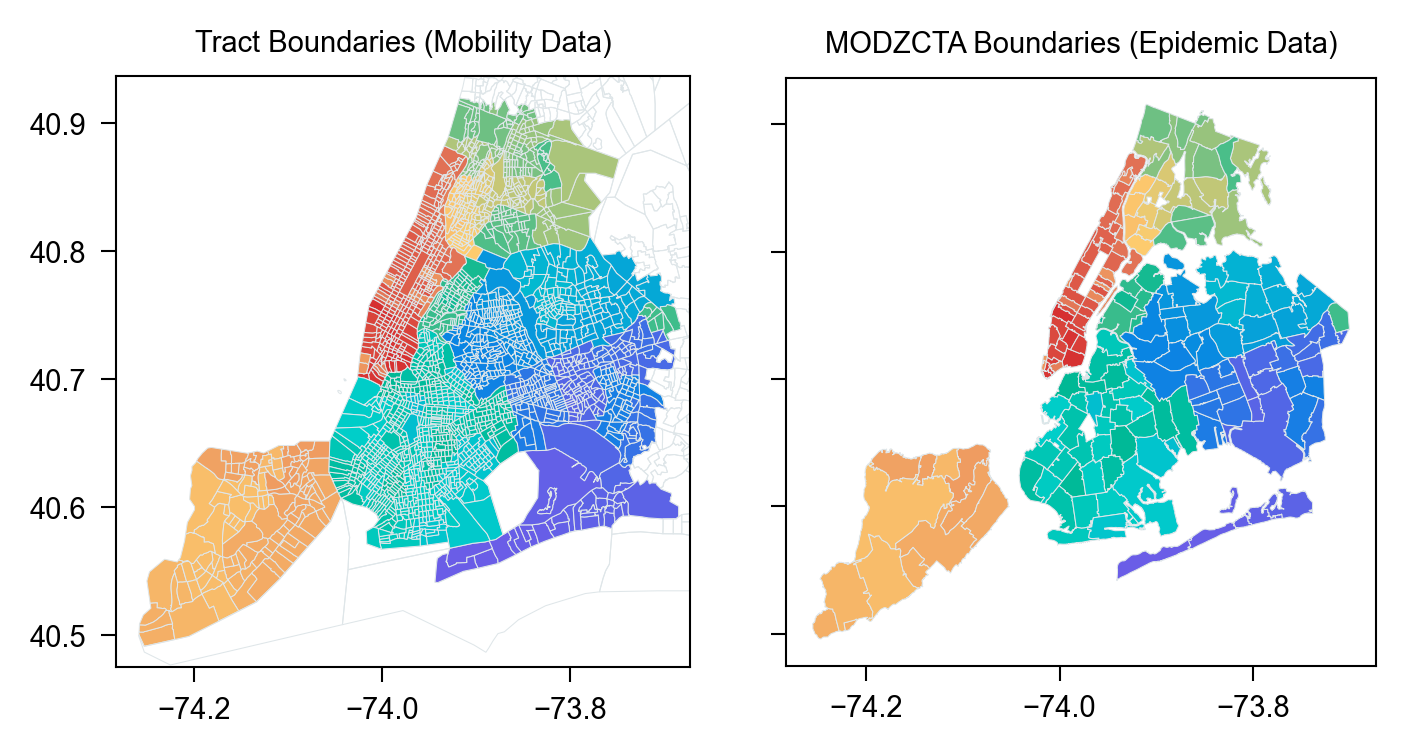

In [5]:
import os
import json
import zipfile
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

# see https://github.com/nychealth/coronavirus-data/tree/master/Geography-resources#geo-files for more information
save_and_cache('https://github.com/nychealth/coronavirus-data/raw/master/Geography-resources/MODZCTA_2010.shp',
            '../data/epidemic/MODZCTA_2010.shp')
save_and_cache('https://github.com/nychealth/coronavirus-data/raw/master/Geography-resources/MODZCTA_2010.shx',
            '../data/epidemic/MODZCTA_2010.shx')
save_and_cache('https://github.com/nychealth/coronavirus-data/raw/master/Geography-resources/MODZCTA_2010.prj',
            '../data/epidemic/MODZCTA_2010.prj')
save_and_cache('https://github.com/nychealth/coronavirus-data/raw/master/Geography-resources/MODZCTA_2010.dbf',
            '../data/epidemic/MODZCTA_2010.dbf')
modzcta_gdf = gpd.read_file('../data/epidemic/MODZCTA_2010.shp')[["MODZCTA", "geometry"]]
modzcta_gdf = modzcta_gdf[modzcta_gdf['MODZCTA'] != '99999']

# see https://www2.census.gov/geo/tiger/TIGER2020/2020_TL_Shapefiles_File_Name_Definitions.pdf and https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.2020.html#list-tab-240499709 for more information
save_and_cache('https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_36_tract.zip', '../data/epidemic/tl_2020_36_tract.zip')
tract_gdf = gpd.read_file('../data/epidemic/tl_2020_36_tract.zip')[["GEOID", "geometry"]]

# 将两个 GeoDataFrame 转换到同一个坐标系
modzcta_gdf = modzcta_gdf.to_crs(tract_gdf.crs)

save_path = '../data/epidemic/tract2modzcta.json'
if os.path.exists(save_path):
    print('Loading cached Tract2MODZCTA mapping...')
    tract2modzcta = json.load(open(save_path, 'r'))
else:
    # 使用 sjoin 方法将两个 GeoDataFrame 进行空间连接 —— 不能用，因为可能有多对多的关系
    # joined_gdf = gpd.sjoin(tract_gdf, modzcta_gdf, how='inner', predicate='intersects')

    # 手动进行空间连接
    results = []
    for _, tract_row in tqdm(tract_gdf.iterrows(), total=len(tract_gdf), desc='Joining Tract and MODZCTA'):
        for _, modzcta_row in tqdm(modzcta_gdf.iterrows(), total=len(modzcta_gdf), disable=True):
            overlap_area = tract_row['geometry'].intersection(modzcta_row['geometry']).area
            if overlap_area > 0:
                results.append({
                    'Tract': tract_row['GEOID'],
                    'MODZCTA': modzcta_row['MODZCTA'],
                    'OverlapArea': overlap_area
                })
    df = pd.DataFrame(results)
    df = df.loc[df.groupby('Tract')['OverlapArea'].idxmax()]
    df = df[df['MODZCTA'] != '99999']
    tract2modzcta = dict(zip(df['Tract'], df['MODZCTA']))

    json.dump(tract2modzcta, open(save_path, 'w'))

from ND2.utils import get_fig
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize
myhsv = LinearSegmentedColormap.from_list('myhsv', ['#d63031', '#e17055', '#fdcb6e', '#00b894', '#00cec9', '#0984e3', '#6c5ce7'])
# norm = Normalize(vmin=min(node), vmax=max(node))
norm = Normalize(vmin=0, vmax=len(node))

fi, fig, axes = get_fig(1, 2, AW=5.0, sharex=True, sharey=True)
modzcta_gdf.plot(ax=axes[1], color=myhsv(norm(modzcta_gdf.index)), linewidth=0.25, edgecolor='#dfe6e9')
axes[1].set_xlim(*axes[1].get_xlim()) # fix aspect ratio
axes[1].set_ylim(*axes[1].get_ylim())
axes[1].set_title('MODZCTA Boundaries (Epidemic Data)')

tract_gdf.plot(ax=axes[0], color=myhsv(norm(
    tract_gdf['GEOID'].map(tract2modzcta).map({i:j for i, j in zip(modzcta_gdf['MODZCTA'], modzcta_gdf.index)})
)), linewidth=0.25, edgecolor='#dfe6e9')
axes[0].set_title('Tract Boundaries (Mobility Data)')


In [6]:
import gzip
import shutil
import pandas as pd

# https://lehd.ces.census.gov/data/ 提供的 OD 数据 (https://lehd.ces.census.gov/data/lodes/LODES8/ny/od/ny_od_main_JT00_2020.csv.gz)，参考 https://lehd.ces.census.gov/data/lodes/LODES8/LODESTechDoc8.1.pdf
save_and_cache('https://lehd.ces.census.gov/data/lodes/LODES8/ny/od/ny_od_main_JT00_2020.csv.gz',
                '../data/epidemic/ny_od_main_JT00_2020.csv.gz')
if not os.path.exists('../data/epidemic/ny_od_main_JT00_2020.csv'):
    with gzip.open('../data/epidemic/ny_od_main_JT00_2020.csv.gz', 'rb') as f:
        shutil.copyfileobj(f, open('../data/epidemic/ny_od_main_JT00_2020.csv', 'wb'))
df = pd.read_csv('../data/epidemic/ny_od_main_JT00_2020.csv', comment='#')
# 15-digits BLOCK CODE (state(2), country(3), tract(6), block(4)) -> 11-digits TRACT CODE
df['w_geocode'] = df['w_geocode'].astype(str).str.slice(0, 11)
df['h_geocode'] = df['h_geocode'].astype(str).str.slice(0, 11)
df['w_modzcta'] = df['w_geocode'].map(tract2modzcta)
df['h_modzcta'] = df['h_geocode'].map(tract2modzcta)

## 另一种 Crosswalk 方法，感觉不如上面的方法好
## https://lehd.ces.census.gov/data/ 提供的 TRACT -> ZCTA crosswalk 文件
# save_and_cache('https://lehd.ces.census.gov/data/lodes/LODES8/ny/ny_xwalk.csv.gz',
#                 '../data/ny_xwalk.csv.gz')
# if not os.path.exists('../data/ny_xwalk.csv'):
#     with gzip.open('../data/ny_xwalk.csv.gz', 'rb') as f:
#         shutil.copyfileobj(f, open('../data/ny_xwalk.csv', 'wb'))
# _df = pd.read_csv('../data/ny_xwalk.csv', dtype=str)
# trct2zcta = dict(zip(_df['trct'], _df['zcta']))
## NYC COVID19 提供的 ZCTA -> MODZCTA crosswalk 文件
# save_and_cache('https://github.com/nychealth/coronavirus-data/raw/master/Geography-resources/ZCTA-to-MODZCTA.csv',
#                 '../data/ZCTA-to-MODZCTA.csv')
# _df = pd.read_csv('../data/ZCTA-to-MODZCTA.csv', dtype=str)
# zcta2modzcta = dict(zip(_df['ZCTA'], _df['MODZCTA']))
# df['w_modzcta2'] = df['w_geocode'].map(trct2zcta).map(zcta2modzcta)
# df['h_modzcta2'] = df['h_geocode'].map(trct2zcta).map(zcta2modzcta)
# df.dropna(subset=['w_modzcta2', 'h_modzcta2'])

# 排除没有有效的 MODZCTA 信息的记录
df['w_modzcta'] = df['w_modzcta'].replace('99999', pd.NA)
df['h_modzcta'] = df['h_modzcta'].replace('99999', pd.NA)
df2 = df.copy()
df.dropna(subset=['w_modzcta', 'h_modzcta'], inplace=True)
print(f'Filtered {len(df2) - len(df)} records with missing MODZCTA information, keeping {len(df)/len(df2):%} records')

df = df[['w_modzcta', 'h_modzcta', 'S000']]
df.columns = ['source', 'destination', 'flow']
# 汇总
df = df.groupby(['source', 'destination']).sum().reset_index()
# 排除自己到自己的流量
df = df[df['source'] != df['destination']]
# 排除不在 node 中的记录
df = df[df['source'].isin(node) & df['destination'].isin(node)]
assert all(np.sort(df['source'].unique()) == np.sort(df['destination'].unique()))
for i in node: assert i in df['source'].unique(), i

df

Filtered 4503309 records with missing MODZCTA information, keeping 36.387588% records


source destination  flow
1      10001       10002  1213
2      10001       10003  1286
3      10001       10004    56
4      10001       10005   211
5      10001       10006   105
...      ...         ...   ...
30404  11697       11434     1
30405  11697       11691    11
30406  11697       11692     3
30407  11697       11693    11
30408  11697       11694    52

[30233 rows x 3 columns]

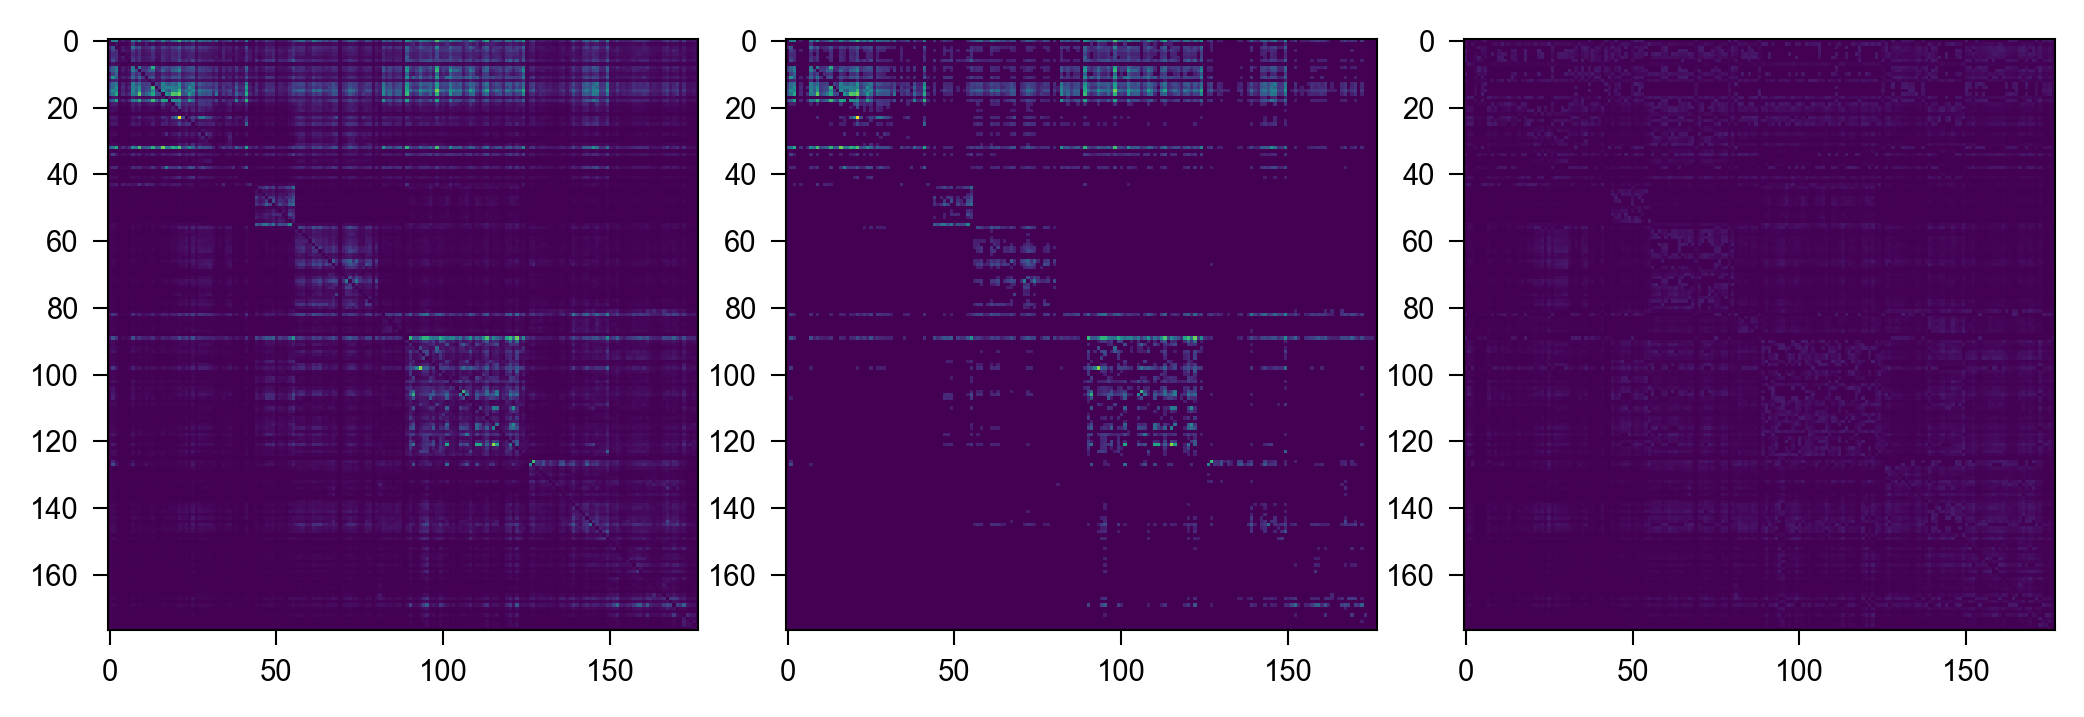

In [8]:
D = 20
df_sparse = df.copy()
df_sparse.sort_values('flow', ascending=False, inplace=True)
df_sparse = df_sparse[:D*len(node)]
df_sparse

from ND2.utils import get_fig
from matplotlib.colors import LogNorm, Normalize
fi, fig, axes = get_fig(1, 3, AW=5)
norm = Normalize(vmin=0, vmax=df['flow'].max())
pivot1 = df.pivot_table(index='source', columns='destination', values='flow', fill_value=0, aggfunc='sum').reindex(index=node, columns=node, fill_value=0)
pivot2 = df_sparse.pivot_table(index='source', columns='destination', values='flow', fill_value=0, aggfunc='sum').reindex(index=node, columns=node, fill_value=0)
axes[0].imshow(pivot1.values, norm=norm)
axes[1].imshow(pivot2.values, norm=norm)
axes[2].imshow(pivot1.values - pivot2.values, norm=norm)
plt.show()

In [9]:
df_sparse

source destination  flow
4090   10027       10025  2806
21161  11235       11229  2343
17081  11211       11206  2311
2752   10018       11211  2229
2852   10019       10025  2223
...      ...         ...   ...
20641  11232       11238   210
17009  11211       10025   210
3475   10023       11226   210
2890   10019       10454   210
29809  11691       11208   210

[3540 rows x 3 columns]

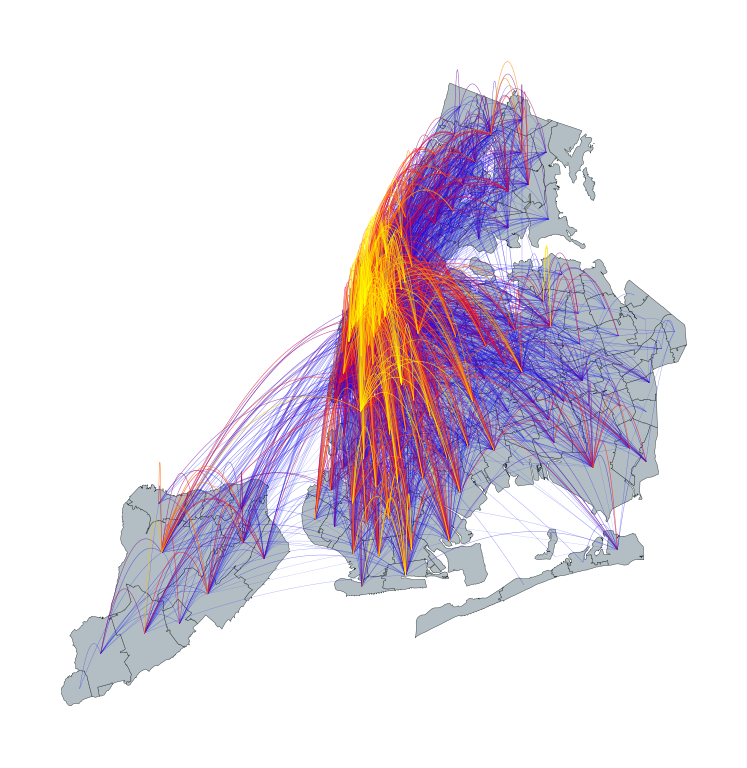

In [10]:
from ND2.utils.plot import get_fig, plotOD

data = df_sparse
data.columns = ['source', 'destination', 'flow']
gdf = modzcta_gdf[['MODZCTA', 'geometry']]
gdf.columns = ['NAME', 'geometry']

fi, fig, axes = get_fig(1, 1, AW=3*2, A_ratio=1, LM=0, RM=0, BM=0, TM=0.0, lw=1.0, fontsize=14)
gdf.plot(ax=axes[0], color='#b2bec3', edgecolor='#2d3436', linewidth=0.1)
location = {row['NAME']: row['geometry'].centroid.coords[0] for _, row in gdf.iterrows()}
plotOD(axes[0], data['source'], data['destination'], data['flow'], location, linetype='parabola')
axes[0].axis('off')
fig.savefig('../plot/epidemic/ODinNYC.png', dpi=600, transparent=True)
fig.savefig('../plot/epidemic/ODinNYC.svg', transparent=True)

Drawing MODZCTA Boundaries: 100%|██████████| 177/177 [00:00<00:00, 1623.85it/s]


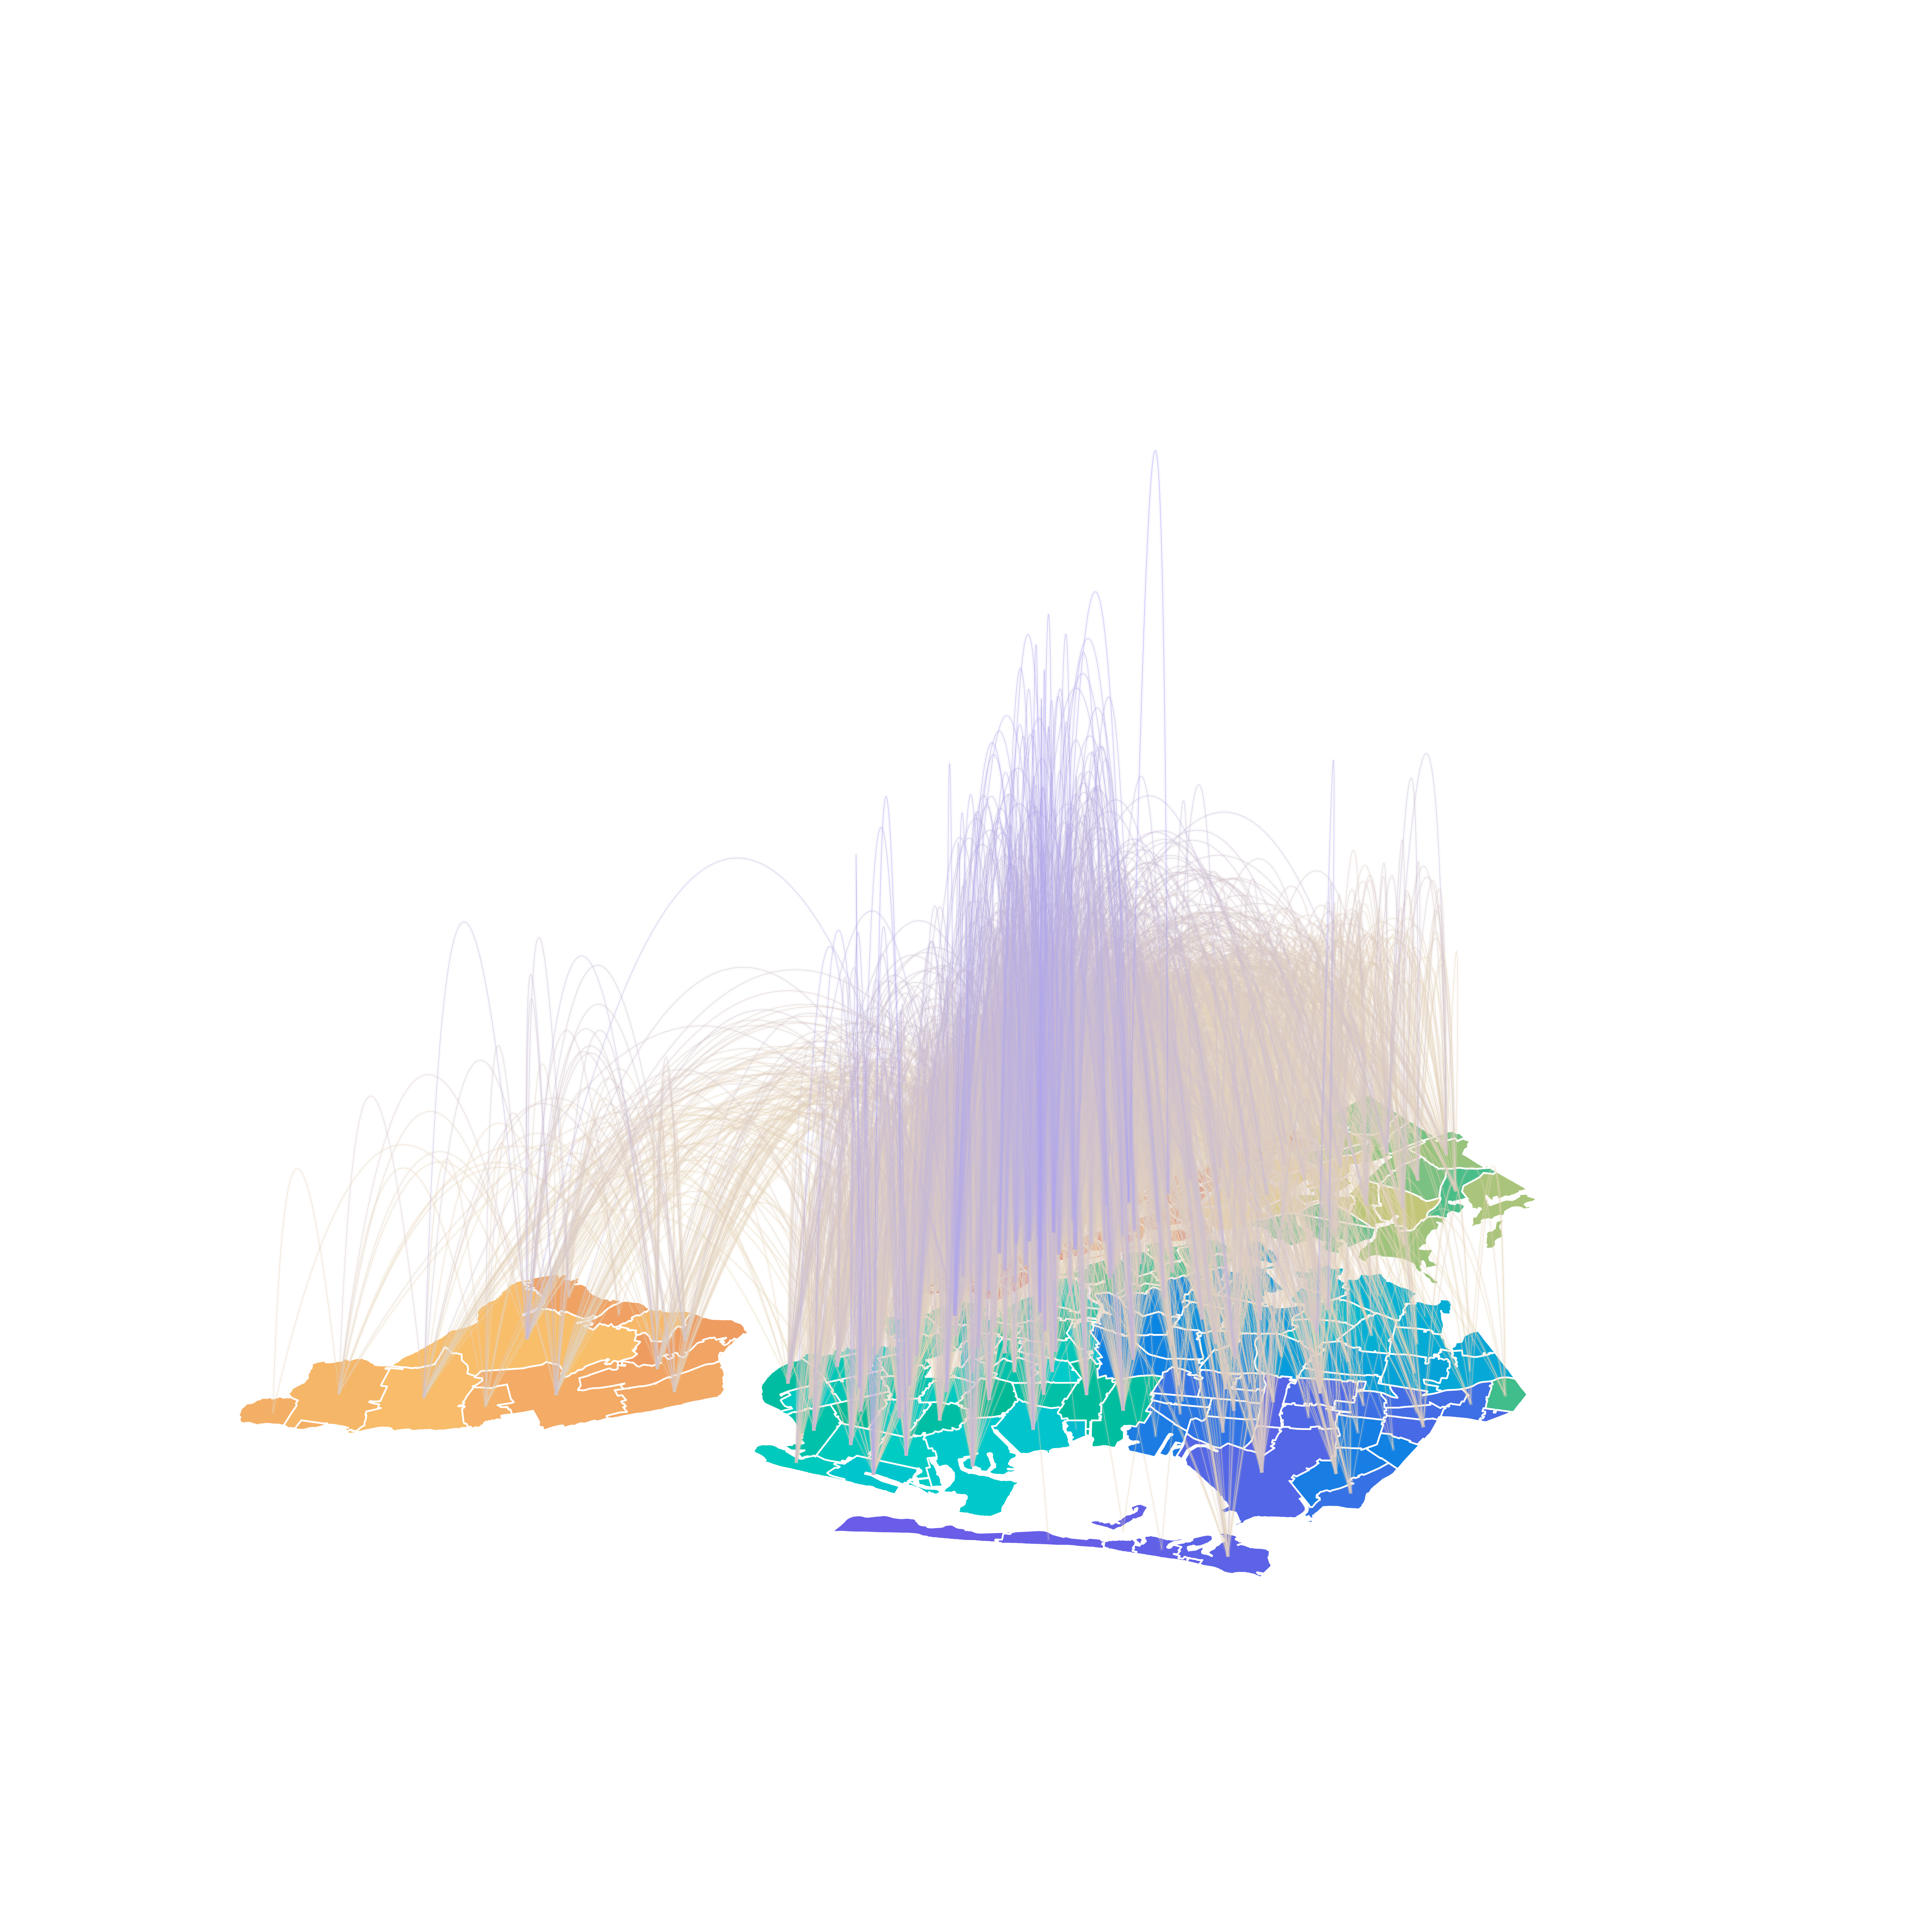

In [11]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

data = df_sparse.copy()

# 下载美国州界数据
gdf = modzcta_gdf[['MODZCTA', 'geometry']]
gdf.columns = ['NAME', 'geometry']

fig = plt.figure(figsize=(12, 8), dpi=600)
ax = fig.add_subplot(111, projection='3d')

# 绘制 OD 线路
center_dict = {row['NAME']:row['geometry'].centroid.coords[0] for _, row in gdf.iterrows()}
myhot = LinearSegmentedColormap.from_list('myhot', ['#ffeaa7', '#a29bfe'], gamma=0.6)
norm = Normalize(vmin=0, vmax=data['flow'].max())
for idx, row in tqdm(data.iterrows(), total=len(data), desc='Drawing OD Flow'):
    x1, y1 = center_dict[row['source']]
    x2, y2 = center_dict[row['destination']]
    if x1 == x2 and y1 == y2: continue
    height = 0.1 * (row['flow'] + 0.3 * data['flow'].max())  # 根据流量设置高度，可以调整比例
    t = np.linspace(0, 1, num=100)
    x = x1 + (x2 - x1) * t
    y = y1 + (y2 - y1) * t
    z = height * 4 * t * (1 - t)  # 抛物线方程
    ax.plot(x, y, z, color=myhot(norm(row['flow'])), linewidth=1.0, zorder=10000+row['flow'], alpha=0.08)
    ax.plot(x, y, z, color=myhot(norm(row['flow'])), linewidth=0.1, zorder=10000+row['flow'], alpha=1.0)

ax.set_xlim(*ax.get_xlim()) # fix aspect ratio
ax.set_ylim(*ax.get_ylim())

# 绘制区域
myhsv = LinearSegmentedColormap.from_list('myhsv', ['#d63031', '#e17055', '#fdcb6e', '#00b894', '#00cec9', '#0984e3', '#6c5ce7'])
norm = Normalize(vmin=0, vmax=len(gdf))
for idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc='Drawing MODZCTA Boundaries'):
    if row['geometry'].geom_type == 'Polygon':
        x, y = row['geometry'].exterior.xy
        poly_collection = Poly3DCollection([list(zip(x, y, [0]*len(x)))], color=myhsv(norm(idx)), zorder=10, linewidth=0.5, edgecolor='white')
        ax.add_collection3d(poly_collection)
    elif row['geometry'].geom_type == 'MultiPolygon':
        for polygon in row['geometry'].geoms:
            x, y = polygon.exterior.xy
            poly_collection = Poly3DCollection([list(zip(x, y, [0]*len(x)))], color=myhsv(norm(idx)), zorder=10, linewidth=0.5, edgecolor='white')
            ax.add_collection3d(poly_collection)

# 设置视角和标签
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# ax.set_title('OD Flow')
ax.axis('off')

# X = np.linspace(*ax.get_xlim(), 10)
# Y = np.linspace(*ax.get_ylim(), 10)
# X, Y = np.meshgrid(X, Y)
# Z = np.zeros_like(X)
# ax.plot_surface(X, Y, Z, zorder=0, color='#000034', alpha=0.1)

# ax.set_facecolor('lightblue')
fig.tight_layout()

plt.show()

# 人口数据

In [12]:
import gzip
import shutil
import pandas as pd

# NYC COVID19 提供的 ZCTA -> MODZCTA crosswalk 文件
save_and_cache('https://github.com/nychealth/coronavirus-data/raw/master/Geography-resources/ZCTA-to-MODZCTA.csv',
                '../data/epidemic/ZCTA-to-MODZCTA.csv')
_df = pd.read_csv('../data/epidemic/ZCTA-to-MODZCTA.csv', dtype=str)
zcta2modzcta = dict(zip(_df['ZCTA'], _df['MODZCTA']))

# https://www.census.gov/programs-surveys/acs/data.html 提供的 2020 年人口普查数据，需要手动筛选下载
df = pd.read_csv('../data/epidemic/population/DECENNIALDHC2020.P1_2024-08-16T222929(1)/DECENNIALDHC2020.P1-Data.csv', comment='#', usecols=['NAME', 'P1_001N'])
df['ZCTA'] = df['NAME'].str.split(' ', expand=True)[1]
df['MODZCTA'] = df['ZCTA'].map(zcta2modzcta)

population = df.dropna(subset=['MODZCTA']).groupby('MODZCTA')['P1_001N'].sum().reindex(node)
population

MODZCTA
10001    32837
10002    82155
10003    57076
10004     4287
10005    10639
         ...  
11691    64673
11692    22776
11693    12467
11694    19780
11697     4468
Name: P1_001N, Length: 177, dtype: int64

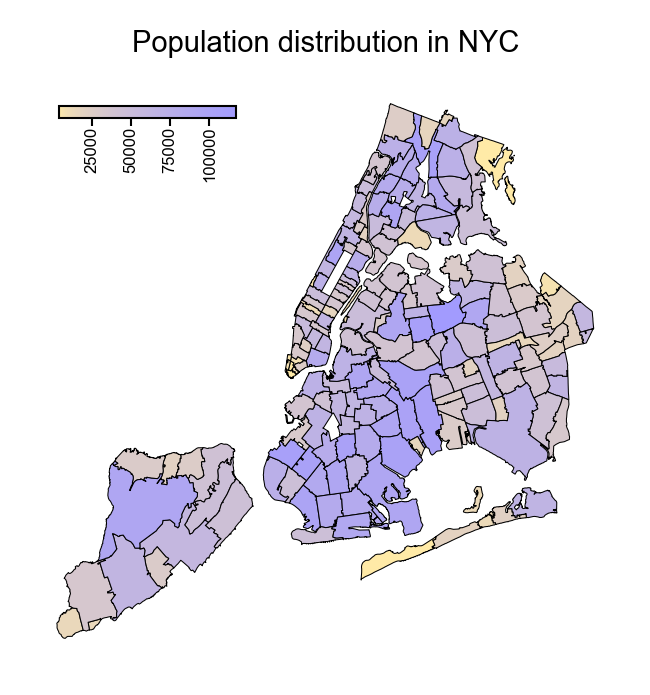

In [14]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap, Normalize
from ND2.utils import get_fig

fi, fig, axes = get_fig(1, 1, AW=5, LM=0, RM=0, BM=0, TM=2.0)

gdf = modzcta_gdf[['MODZCTA', 'geometry']]
value = population[node].values

myhot = LinearSegmentedColormap.from_list('myhot', ['#ffeaa7', '#a29bfe'], gamma=0.6)
norm = Normalize(vmin=min(value), vmax=max(value))
gdf.plot(ax=axes[0], color=myhot(norm(value)), edgecolor='black', linewidth=0.25)

sm = cm.ScalarMappable(cmap=myhot, norm=norm)
sm.set_array([])
cax = inset_axes(axes[0], width="30%", height="2%", loc='upper left', borderpad=1)
plt.colorbar(sm, cax=cax, orientation='horizontal')
cax.xaxis.set_major_locator(plt.MaxNLocator(5))
cax.tick_params(axis='x', labelsize=fi.fontsize-3, rotation=90, pad=0.1, length=2)

axes[0].set_title('Population distribution in NYC')
axes[0].axis('off')
fig.savefig('../plot/epidemic/PopulationinNYC.png', dpi=300, transparent=True)
plt.show()

# 住院数据

In [15]:
# import os
# import requests
# import pandas as pd
# import matplotlib.pyplot as plt

# if not os.path.exists('hosp-by-day.csv'):
#     r = requests.get('https://github.com/nychealth/coronavirus-data/raw/master/trends/hosp-by-day.csv')
#     with open('hosp-by-day.csv', 'wb') as f:
#         f.write(r.content)
# df = pd.read_csv('hosp-by-day.csv', comment='#')
# plt.plot(df[['BX_HOSPITALIZED_COUNT', 'BK_HOSPITALIZED_COUNT', 'MN_HOSPITALIZED_COUNT', 'QN_HOSPITALIZED_COUNT', 'SI_HOSPITALIZED_COUNT']])
# plt.show()

# 保存数据

In [16]:
import json

node2idx = {n:idx for idx, n in enumerate(node)}
df_sparse['source_idx'] = df_sparse['source'].map(node2idx)
df_sparse['destination_idx'] = df_sparse['destination'].map(node2idx)
G = df_sparse[['source_idx', 'destination_idx']].values
A = np.zeros((len(node), len(node),), dtype=int)
A[G[:, 0], G[:, 1]] = 1

save = {}
save['node'] = node.tolist() # (N=177,)
save['time'] = time.tolist() # (T=232,)
save['case'] = case.tolist() # (T=232, N=177)
save['flow'] = df_sparse['flow'].tolist() # (E=3540,)
save['population'] = population.values.tolist() # (N=177,)
save['A'] = A.tolist() # (N=177, N=177)
save['G'] = G.tolist() # (E=3540, 2)
with open('../data/epidemic/COVID19inNYC.json', 'w') as f:
    json.dump(save, f)

for key, value in save.items():
    print(f'{key:10} -> {np.array(value).shape}')

node       -> (177,)
time       -> (163,)
case       -> (163, 177)
flow       -> (3540,)
population -> (177,)
A          -> (177, 177)
G          -> (3540, 2)
